New simulations after choosing $\zeta$ to match old 71cm data and updating VBR numbers including the B state

# Set up constants, global functions etc

In [1]:
# using Revise, BeamPropagation, Distributions, StatsBase, StaticArrays, PhysicalConstants.CODATA2018, Plots, BenchmarkTools
using BeamPropagation, Distributions, PhysicalConstants.CODATA2018, StatsBase, StaticArrays, Plots, BenchmarkTools, DelimitedFiles, StructArrays

In [2]:
const h = PlanckConstant.val
const ħ = h / 2π
const λ = @with_unit 626 "nm"
const k = 2π / λ
const m = @with_unit 57 "u"
const Δv = ħ * k / m
const Γ = 1/(25e-9)
;

In [3]:
vz_μ = @with_unit 125 "m/s"
vz_σ = @with_unit 25 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 25 "m/s" #approximately 4 K
exit_radius = @with_unit 4 "mm"
;

In [4]:
const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(0, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [5]:
@inline function random_unit3Dvector()
    θ = rand(Uniform(0, 2π))
    z = rand(Uniform(-1, 1))
    return @SVector [sqrt(1-z^2)*cos(θ), sqrt(1-z^2)*sin(θ), z]
end
;

## 81cm beamline

In [6]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 81  "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 1 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [7]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len)

@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        v = particles.v[i]
        s.vzs[idx] = v[3]
    end
    return nothing
end
;

In [8]:
#need to double check these positions
@inline function transverse_on(z)
    if 0.191 < z < 0.350     # 1st transverse region # 17.5 - 20 cm after cell
        return true
    elseif (0.502 - 0.02) < z < (0.502 + 0.02)  # 2nd transverse region # 45 - 50 cm after cell
        return true
    elseif (0.756 - 0.008) < z < (0.756 + 0.008)  # 3rd transverse region # 56 - 61 cm after cell
        return true
    else
        return false
    end
end
;

In [52]:
#updated VBRs 9/28/21
VBRs = Weights([
    0.946961,     # to 000
    0.046456,     # 100
    2.585e-3,     # 0200
    1.708e-3,     # 200
    6.38e-4,     # 0220
    8.16e-4,     # 0110
    3.58e-4,     # 0110, N=2
    1.95e-4,     # 1200
    6.5e-5,     # 300
    4.9e-5,     # 1220
    6.0e-5,     # 110 N=1
    2.4e-5,     # 110, N=2
    2.8e-5,     # 030 N=1
    5.7e-5      # other statess
])

addressed = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 0110, N=2
    true,   # 1200
    true,   # 300
    true,   # 1220
    true,   # 110
    false,  # 110, N=2
    false,  # 030 N=1
    false   # other states
]

transverse = [
    false,  # to 000
    false,   # 100
    false,  # 0200
    false,  # 200
    false,  # 0220
    false,  # 0110
    false,  # 0110, N=2
    false,  # 1200
    false,   # 300
    true,   # 1220
    true,   # 110
    false,   # 110, N=2
    false,  # 030 N=1
    false   # other states
]

# transverse = [
#     false,  # to 000
#     false,   # 100
#     false,  # 0200
#     false,  # 200
#     false,  # 0220
#     false,  # 0110
#     false,  # 0110, N=2
#     false,  # 1200
#     false,   # 300
#     false,   # 1220
#     false,   # 110
#     false,   # 110, N=2
#     false,  # 030 N=1
#     false   # other states
# ]

λs = 1e-9 .* [
    626,
    574,
    629,
    650,
    630,
    566,
    623,
    651,
    595,
    646,
    566,
    648,
    600,
    600
]

;

The approach is to set the timestep equal to 1/scattering rate for each molecule. One then updates the velocity vector after each timestep to reflect a single photon scatter. In this way, the acceleration is always zero, and the velocities are instead updated according to individual photon scattering events

In [10]:
@inline function beamwaist(z, p)
    
    return (z*(p.ddet-p.dcell)/(detect_zloc)+p.dcell)/2
    
end
;

In [11]:
@inline function velocity_vector(r, v, Δvphot, p)
    
    focus_offset = p.dcell/(p.ddet-p.dcell)*detect_zloc
    z = r[3] + focus_offset
    
    squared_length = r[1]^2 + r[2]^2 + z^2
    
    x_comp = r[1] / squared_length
    y_comp = r[2] / squared_length
    z_comp = z / squared_length
    
    return @SVector [v[1] - Δvphot * x_comp, v[2] - Δvphot * y_comp, v[3] - Δvphot * z_comp]
    
end

;

In [40]:
# the interesting physics (scattering rate vs. position, velocity etc) is contained in this function
# scattering rate expression taken from effective two-level model worked out in Mathematica notebook, plus an overall reduction factor ζ in the scattering rate
@inline function Rscatt(r,v,p)
    vmin = -5.
    vmax = 150.
    if vmin < v[3] < vmax
        waist = beamwaist(r[3],p)
#         power = 1200 #mW
        Isat = 3.4 #mW/cm^2
        I0 = 2*p.power/(pi*waist^2)*1e-4 #mW/cm^2
        Ir = I0*exp(-2*(r[1]^2+r[2]^2)/(waist^2))
        Ng = 12 #number of hyperfine ground states
        Ne = 4 #number of hyperfine excited states
        Nf = 65 #number of frequency components (chosen for 300 MHz spread and 4.6 MHz spacing)
        Γeff = Γ*2*Ne/(Ne+Ng)
        seff = (Ng+Ne)/(2*Ng)*2.1*Ir/Nf/Isat
        Rsc = p.ζ*Γeff/2 * seff/(1+seff)
    else
        Rsc = 0.
    end
    return Rsc
end

@inline function update_Rsc(r, v, p)
    Rsc = Rscatt(r,v,p)
    if iszero(Rsc)
        dt = p.dt0
    else
        dt = 1/Rsc
    end
    return dt
end

;

In [41]:
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200 #mW
ζ = 0.15
p = @params (ddet, dcell, power, ζ)
rs = 0:0.01:0.81
Rscatts0 = zeros(size(rs,1))
Rscatts1 = zeros(size(rs,1))
Rscatts2 = zeros(size(rs,1))
Rscatts3 = zeros(size(rs,1))
Rscatts4 = zeros(size(rs,1))
Rscatts5 = zeros(size(rs,1))
for i in 1:length(rs)
    Rscatts0[i] = Rscatt(SVector(0.,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts1[i] = Rscatt(SVector(1e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts2[i] = Rscatt(SVector(2e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts3[i] = Rscatt(SVector(3e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts4[i] = Rscatt(SVector(4e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts5[i] = Rscatt(SVector(5e-3,0.,rs[i]),SVector(0.,0.,100.),p)
end

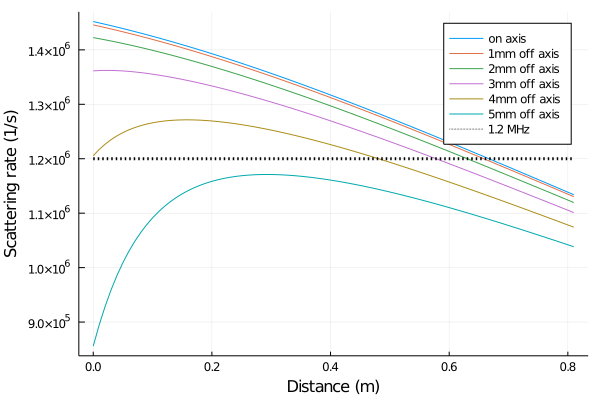

In [42]:
plot(rs,Rscatts0, label = "on axis")
plot!(rs,Rscatts1, label = "1mm off axis")
plot!(rs,Rscatts2, label = "2mm off axis")
plot!(rs,Rscatts3, label = "3mm off axis")
plot!(rs,Rscatts4, label = "4mm off axis")
plot!(rs,Rscatts5, label = "5mm off axis")
plot!([0.,0.81],[1.2e6,1.2e6],lw = 3, linestyle = :dot, color = "black", label = "1.2 MHz")
xlabel!("Distance (m)")
ylabel!("Scattering rate (1/s)")

In [43]:
@inline function update(particles, p, s, dt)
    for i in 1:size(particles, 1)
        idx   = particles.idx[i]
        state = s.states[idx]
        
        r = particles.r[i]
        v = particles.v[i]
        
#         s.total_time[idx] += particles.dt[i]
        
        if ~p.noslow && p.addressed[state] && (~p.transverse[state] || transverse_on(r[3]))
            dt′ = update_Rsc(r,v,p)
            state′ = sample(1:14,p.VBRs)
            particles.dt[i] = dt′
            particles.use_adaptive[i] = false
            v′ = velocity_vector(r, v, Δv, p)
            v′ += Δv .* random_unit3Dvector()
            s.photons[idx] += 1
        else
            state′ = state
            v′ = v
            particles.use_adaptive[i] = true
        end
        s.states[idx] = state′
        s.vzs[idx] = v′[3]
        particles.v[i] = v′
        
        s.detectable[idx] |= is_detectable(r) #updating "or" operator (either s.detectable[idx] is true, or updates s.detectable[idx] to is_detectable(r))
    end
    return nothing
end

@inline function f(idx, r, v, p)
    
    return SVector(0., 0., 0.)
    
end

;

In [53]:
# Parameters required by beam propagation simulation
n = Int64(15e6)
save_every = 150
delete_every = 50
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(1e5)
alg = "rkf12"
use_adaptive = true
;

In [61]:
dt0 = 1e-5
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200 #mW
ζ = 0.15

noslow = false
p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ)
s = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)

  4.149796 seconds (15.00 M allocations: 5.839 GiB, 26.27% gc time)


In [62]:
dt0 = 1e-5
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200 #mW
ζ = 0.15

noslow = true
p0 = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ)
s0 = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, dt_min, dt_max, abstol)

  4.067622 seconds (15.00 M allocations: 5.839 GiB, 48.09% gc time)


In [63]:
bright = [addressed[final_state] for final_state in s.states];

With (1220) and (110) N=1 in transverse

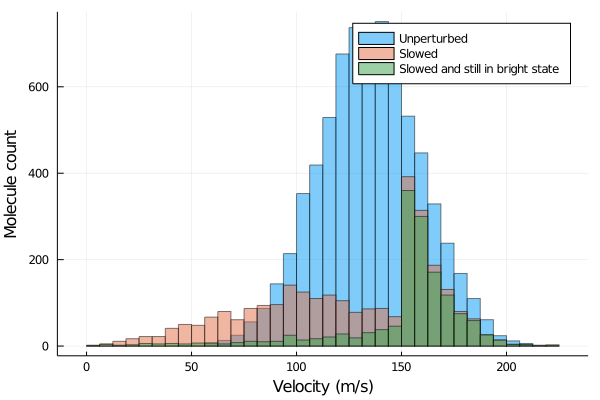

In [64]:
barhist(s0.vzs[s0.detectable], bins=0:25/4:225, alpha=0.5, label="Unperturbed")
barhist!(s.vzs[s.detectable], bins=0:25/4:225, alpha=0.5, label="Slowed")
barhist!(s.vzs[s.detectable .& bright], bins=0:25/4:225, alpha=0.5, label="Slowed and still in bright state")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [65]:
v_low_cut = 10
v_low = 0 .< s.vzs .< v_low_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected below ", v_low_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7343
Number detectable in slowed beam: 2841
Number detected (i.e. in bright states) in slowed beam: 1463
Number detected below 10 m/s in slowed beam: 3
Fraction of unperturbed below 10 m/s: 0.0004085523627944982
Number slowed from 2e7 initial: 8171.047255889964


In [66]:
v_low_cut = 17.5
v_high_cut = 22.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7343
Number detectable in slowed beam: 2841
Number detected (i.e. in bright states) in slowed beam: 1463
Number detected between 17.5 and 22.5 m/s in slowed beam: 2
Fraction of unperturbed below 17.5 m/s: 0.00027236824186299875
Number slowed from 2e7 initial: 5447.364837259975


In [67]:
v_low_cut = 37.5
v_high_cut = 42.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7343
Number detectable in slowed beam: 2841
Number detected (i.e. in bright states) in slowed beam: 1463
Number detected between 37.5 and 42.5 m/s in slowed beam: 4
Fraction of unperturbed below 37.5 m/s: 0.0005447364837259975
Number slowed from 2e7 initial: 10894.72967451995


All longitudinal

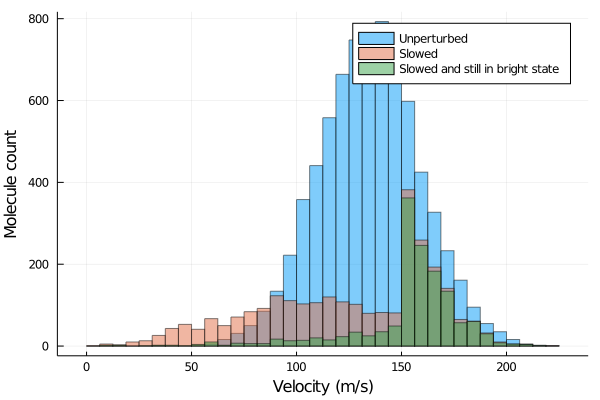

In [48]:
barhist(s0.vzs[s0.detectable], bins=0:25/4:225, alpha=0.5, label="Unperturbed")
barhist!(s.vzs[s.detectable], bins=0:25/4:225, alpha=0.5, label="Slowed")
barhist!(s.vzs[s.detectable .& bright], bins=0:25/4:225, alpha=0.5, label="Slowed and still in bright state")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [49]:
v_low_cut = 10
v_low = 0 .< s.vzs .< v_low_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected below ", v_low_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7471
Number detectable in slowed beam: 2729
Number detected (i.e. in bright states) in slowed beam: 1380
Number detected below 10 m/s in slowed beam: 1
Fraction of unperturbed below 10 m/s: 0.0001338508901084192
Number slowed from 2e7 initial: 2677.017802168384


In [50]:
v_low_cut = 17.5
v_high_cut = 22.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7471
Number detectable in slowed beam: 2729
Number detected (i.e. in bright states) in slowed beam: 1380
Number detected between 17.5 and 22.5 m/s in slowed beam: 0
Fraction of unperturbed below 17.5 m/s: 0.0
Number slowed from 2e7 initial: 0.0


In [51]:
v_low_cut = 37.5
v_high_cut = 42.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7471
Number detectable in slowed beam: 2729
Number detected (i.e. in bright states) in slowed beam: 1380
Number detected between 37.5 and 42.5 m/s in slowed beam: 2
Fraction of unperturbed below 37.5 m/s: 0.0002677017802168384
Number slowed from 2e7 initial: 5354.035604336768


## 65cm beamline

In [113]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 65  "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 1 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [114]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len)

@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        v = particles.v[i]
        s.vzs[idx] = v[3]
    end
    return nothing
end
;

In [115]:
#need to double check these positions
@inline function transverse_on(z)
    return false
end
;

In [116]:
#updated VBRs 9/28/21
VBRs = Weights([
    0.946961,     # to 000
    0.046456,     # 100
    2.585e-3,     # 0200
    1.708e-3,     # 200
    6.38e-4,     # 0220
    8.16e-4,     # 0110
    3.58e-4,     # 0110, N=2
    1.95e-4,     # 1200
    6.5e-5,     # 300
    4.9e-5,     # 1220
    6.0e-5,     # 110 N=1
    2.4e-5,     # 110, N=2
    2.8e-5,     # 030 N=1
    5.7e-5      # other statess
])

addressed = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 0110, N=2
    true,   # 1200
    true,   # 300
    true,   # 1220
    true,   # 110
    false,  # 110, N=2
    false,  # 030 N=1
    false   # other states
]

transverse = [
    false,  # to 000
    false,   # 100
    false,  # 0200
    false,  # 200
    false,  # 0220
    false,  # 0110
    false,  # 0110, N=2
    false,  # 1200
    false,   # 300
    false,   # 1220
    false,   # 110
    false,   # 110, N=2
    false,  # 030 N=1
    false   # other states
]

λs = 1e-9 .* [
    626,
    574,
    629,
    650,
    630,
    566,
    623,
    651,
    595,
    646,
    566,
    648,
    600,
    600
]

;

The approach is to set the timestep equal to 1/scattering rate for each molecule. One then updates the velocity vector after each timestep to reflect a single photon scatter. In this way, the acceleration is always zero, and the velocities are instead updated according to individual photon scattering events

In [117]:
@inline function beamwaist(z, p)
    
    return (z*(p.ddet-p.dcell)/(detect_zloc)+p.dcell)/2
    
end
;

In [118]:
@inline function velocity_vector(r, v, Δvphot, p)
    
    focus_offset = p.dcell/(p.ddet-p.dcell)*detect_zloc
    z = r[3] + focus_offset
    
    squared_length = r[1]^2 + r[2]^2 + z^2
    
    x_comp = r[1] / squared_length
    y_comp = r[2] / squared_length
    z_comp = z / squared_length
    
    return @SVector [v[1] - Δvphot * x_comp, v[2] - Δvphot * y_comp, v[3] - Δvphot * z_comp]
    
end

;

In [119]:
# the interesting physics (scattering rate vs. position, velocity etc) is contained in this function
# scattering rate expression taken from effective two-level model worked out in Mathematica notebook, plus an overall reduction factor ζ in the scattering rate
@inline function Rscatt(r,v,p)
    vmin = -5.
    vmax = 150.
    if vmin < v[3] < vmax
        waist = beamwaist(r[3],p)
#         power = 1200 #mW
        Isat = 3.4 #mW/cm^2
        I0 = 2*p.power/(pi*waist^2)*1e-4 #mW/cm^2
        Ir = I0*exp(-2*(r[1]^2+r[2]^2)/(waist^2))
        Ng = 12 #number of hyperfine ground states
        Ne = 4 #number of hyperfine excited states
        Nf = 65 #number of frequency components (chosen for 300 MHz spread and 4.6 MHz spacing)
        Γeff = Γ*2*Ne/(Ne+Ng)
        seff = (Ng+Ne)/(2*Ng)*2.1*Ir/Nf/Isat
        Rsc = p.ζ*Γeff/2 * seff/(1+seff)
    else
        Rsc = 0.
    end
    return Rsc
end

@inline function update_Rsc(r, v, p)
    Rsc = Rscatt(r,v,p)
    if iszero(Rsc)
        dt = p.dt0
    else
        dt = 1/Rsc
    end
    return dt
end

;

In [120]:
@inline function update(particles, p, s, dt)
    for i in 1:size(particles, 1)
        idx   = particles.idx[i]
        state = s.states[idx]
        
        r = particles.r[i]
        v = particles.v[i]
        
#         s.total_time[idx] += particles.dt[i]
        
        if ~p.noslow && p.addressed[state] && (~p.transverse[state] || transverse_on(r[3]))
            dt′ = update_Rsc(r,v,p)
            state′ = sample(1:14,p.VBRs)
            particles.dt[i] = dt′
            particles.use_adaptive[i] = false
            v′ = velocity_vector(r, v, Δv, p)
            v′ += Δv .* random_unit3Dvector()
            s.photons[idx] += 1
        else
            state′ = state
            v′ = v
            particles.use_adaptive[i] = true
        end
        s.states[idx] = state′
        s.vzs[idx] = v′[3]
        particles.v[i] = v′
        
        s.detectable[idx] |= is_detectable(r) #updating "or" operator (either s.detectable[idx] is true, or updates s.detectable[idx] to is_detectable(r))
    end
    return nothing
end

@inline function f(idx, r, v, p)
    
    return SVector(0., 0., 0.)
    
end

;

In [121]:
# Parameters required by beam propagation simulation
n = Int64(15e6)
save_every = 150
delete_every = 50
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(1e5)
alg = "rkf12"
use_adaptive = true
;

In [122]:
dt0 = 1e-5
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200 #mW
ζ = 0.15

noslow = false
p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ)
s = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)

  5.812350 seconds (15.42 M allocations: 5.860 GiB, 30.31% gc time)


In [123]:
dt0 = 1e-5
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200 #mW
ζ = 0.15

noslow = true
p0 = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ)
s0 = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, dt_min, dt_max, abstol)

  4.226768 seconds (15.00 M allocations: 5.839 GiB, 46.22% gc time)


In [124]:
bright = [addressed[final_state] for final_state in s.states];

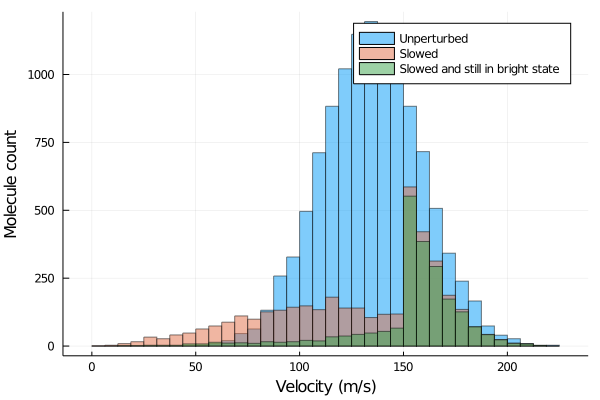

In [125]:
barhist(s0.vzs[s0.detectable], bins=0:25/4:225, alpha=0.5, label="Unperturbed")
barhist!(s.vzs[s.detectable], bins=0:25/4:225, alpha=0.5, label="Slowed")
barhist!(s.vzs[s.detectable .& bright], bins=0:25/4:225, alpha=0.5, label="Slowed and still in bright state")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [126]:
v_low_cut = 10
v_low = 0 .< s.vzs .< v_low_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected below ", v_low_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 11483
Number detectable in slowed beam: 3897
Number detected (i.e. in bright states) in slowed beam: 2129
Number detected below 10 m/s in slowed beam: 0
Fraction of unperturbed below 10 m/s: 0.0
Number slowed from 2e7 initial: 0.0


In [127]:
v_low_cut = 17.5
v_high_cut = 22.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 11483
Number detectable in slowed beam: 3897
Number detected (i.e. in bright states) in slowed beam: 2129
Number detected between 17.5 and 22.5 m/s in slowed beam: 2
Fraction of unperturbed below 17.5 m/s: 0.00017417051293216058
Number slowed from 2e7 initial: 3483.410258643212


In [128]:
v_low_cut = 37.5
v_high_cut = 42.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 11483
Number detectable in slowed beam: 3897
Number detected (i.e. in bright states) in slowed beam: 2129
Number detected between 37.5 and 42.5 m/s in slowed beam: 3
Fraction of unperturbed below 37.5 m/s: 0.00026125576939824087
Number slowed from 2e7 initial: 5225.115387964817


## 65cm beamline, adding (110) N=2

In [129]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 65  "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 1 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [130]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len)

@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        v = particles.v[i]
        s.vzs[idx] = v[3]
    end
    return nothing
end
;

In [131]:
#need to double check these positions
@inline function transverse_on(z)
    return false
end
;

In [132]:
#updated VBRs 9/28/21
VBRs = Weights([
    0.946961,     # to 000
    0.046456,     # 100
    2.585e-3,     # 0200
    1.708e-3,     # 200
    6.38e-4,     # 0220
    8.16e-4,     # 0110
    3.58e-4,     # 0110, N=2
    1.95e-4,     # 1200
    6.5e-5,     # 300
    4.9e-5,     # 1220
    6.0e-5,     # 110 N=1
    2.4e-5,     # 110, N=2
    2.8e-5,     # 030 N=1
    5.7e-5      # other statess
])

addressed = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 0110, N=2
    true,   # 1200
    true,   # 300
    true,   # 1220
    true,   # 110
    true,  # 110, N=2
    false,  # 030 N=1
    false   # other states
]

transverse = [
    false,  # to 000
    false,   # 100
    false,  # 0200
    false,  # 200
    false,  # 0220
    false,  # 0110
    false,  # 0110, N=2
    false,  # 1200
    false,   # 300
    false,   # 1220
    false,   # 110
    false,   # 110, N=2
    false,  # 030 N=1
    false   # other states
]

λs = 1e-9 .* [
    626,
    574,
    629,
    650,
    630,
    566,
    623,
    651,
    595,
    646,
    566,
    648,
    600,
    600
]

;

The approach is to set the timestep equal to 1/scattering rate for each molecule. One then updates the velocity vector after each timestep to reflect a single photon scatter. In this way, the acceleration is always zero, and the velocities are instead updated according to individual photon scattering events

In [133]:
@inline function beamwaist(z, p)
    
    return (z*(p.ddet-p.dcell)/(detect_zloc)+p.dcell)/2
    
end
;

In [134]:
@inline function velocity_vector(r, v, Δvphot, p)
    
    focus_offset = p.dcell/(p.ddet-p.dcell)*detect_zloc
    z = r[3] + focus_offset
    
    squared_length = r[1]^2 + r[2]^2 + z^2
    
    x_comp = r[1] / squared_length
    y_comp = r[2] / squared_length
    z_comp = z / squared_length
    
    return @SVector [v[1] - Δvphot * x_comp, v[2] - Δvphot * y_comp, v[3] - Δvphot * z_comp]
    
end

;

In [135]:
# the interesting physics (scattering rate vs. position, velocity etc) is contained in this function
# scattering rate expression taken from effective two-level model worked out in Mathematica notebook, plus an overall reduction factor ζ in the scattering rate
@inline function Rscatt(r,v,p)
    vmin = -5.
    vmax = 150.
    if vmin < v[3] < vmax
        waist = beamwaist(r[3],p)
#         power = 1200 #mW
        Isat = 3.4 #mW/cm^2
        I0 = 2*p.power/(pi*waist^2)*1e-4 #mW/cm^2
        Ir = I0*exp(-2*(r[1]^2+r[2]^2)/(waist^2))
        Ng = 12 #number of hyperfine ground states
        Ne = 4 #number of hyperfine excited states
        Nf = 65 #number of frequency components (chosen for 300 MHz spread and 4.6 MHz spacing)
        Γeff = Γ*2*Ne/(Ne+Ng)
        seff = (Ng+Ne)/(2*Ng)*2.1*Ir/Nf/Isat
        Rsc = p.ζ*Γeff/2 * seff/(1+seff)
    else
        Rsc = 0.
    end
    return Rsc
end

@inline function update_Rsc(r, v, p)
    Rsc = Rscatt(r,v,p)
    if iszero(Rsc)
        dt = p.dt0
    else
        dt = 1/Rsc
    end
    return dt
end

;

In [136]:
@inline function update(particles, p, s, dt)
    for i in 1:size(particles, 1)
        idx   = particles.idx[i]
        state = s.states[idx]
        
        r = particles.r[i]
        v = particles.v[i]
        
#         s.total_time[idx] += particles.dt[i]
        
        if ~p.noslow && p.addressed[state] && (~p.transverse[state] || transverse_on(r[3]))
            dt′ = update_Rsc(r,v,p)
            state′ = sample(1:14,p.VBRs)
            particles.dt[i] = dt′
            particles.use_adaptive[i] = false
            v′ = velocity_vector(r, v, Δv, p)
            v′ += Δv .* random_unit3Dvector()
            s.photons[idx] += 1
        else
            state′ = state
            v′ = v
            particles.use_adaptive[i] = true
        end
        s.states[idx] = state′
        s.vzs[idx] = v′[3]
        particles.v[i] = v′
        
        s.detectable[idx] |= is_detectable(r) #updating "or" operator (either s.detectable[idx] is true, or updates s.detectable[idx] to is_detectable(r))
    end
    return nothing
end

@inline function f(idx, r, v, p)
    
    return SVector(0., 0., 0.)
    
end

;

In [137]:
# Parameters required by beam propagation simulation
n = Int64(15e6)
save_every = 150
delete_every = 50
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(1e5)
alg = "rkf12"
use_adaptive = true
;

In [138]:
dt0 = 1e-5
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200 #mW
ζ = 0.15

noslow = false
p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ)
s = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)

  4.772976 seconds (15.42 M allocations: 5.860 GiB, 11.02% gc time)


In [139]:
dt0 = 1e-5
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200 #mW
ζ = 0.15

noslow = true
p0 = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ)
s0 = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, dt_min, dt_max, abstol)

  4.377639 seconds (15.00 M allocations: 5.839 GiB, 44.73% gc time)


In [140]:
bright = [addressed[final_state] for final_state in s.states];

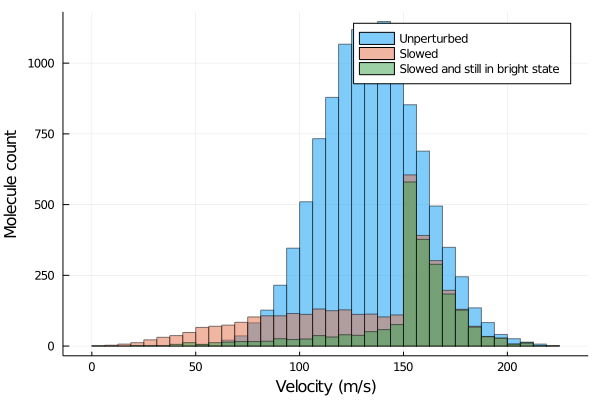

In [141]:
barhist(s0.vzs[s0.detectable], bins=0:25/4:225, alpha=0.5, label="Unperturbed")
barhist!(s.vzs[s.detectable], bins=0:25/4:225, alpha=0.5, label="Slowed")
barhist!(s.vzs[s.detectable .& bright], bins=0:25/4:225, alpha=0.5, label="Slowed and still in bright state")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [142]:
v_low_cut = 10
v_low = 0 .< s.vzs .< v_low_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected below ", v_low_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 11372
Number detectable in slowed beam: 3598
Number detected (i.e. in bright states) in slowed beam: 2217
Number detected below 10 m/s in slowed beam: 1
Fraction of unperturbed below 10 m/s: 8.793527963418924e-5
Number slowed from 2e7 initial: 1758.7055926837847


In [143]:
v_low_cut = 17.5
v_high_cut = 22.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 11372
Number detectable in slowed beam: 3598
Number detected (i.e. in bright states) in slowed beam: 2217
Number detected between 17.5 and 22.5 m/s in slowed beam: 2
Fraction of unperturbed below 17.5 m/s: 0.00017587055926837847
Number slowed from 2e7 initial: 3517.4111853675695


In [144]:
v_low_cut = 37.5
v_high_cut = 42.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 11372
Number detectable in slowed beam: 3598
Number detected (i.e. in bright states) in slowed beam: 2217
Number detected between 37.5 and 42.5 m/s in slowed beam: 4
Fraction of unperturbed below 37.5 m/s: 0.00035174111853675694
Number slowed from 2e7 initial: 7034.822370735139


## 81cm beamline - with low-power shelving beam down the bore?

In [145]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 81  "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 1 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [146]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len)

@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        v = particles.v[i]
        s.vzs[idx] = v[3]
    end
    return nothing
end
;

In [264]:
@inline function transverse_on(z)
    if (0.756 - 0.008) < z < (0.756 + 0.008)     #N=3 repumping
        return true
    else
        return false
    end
end
;

In [178]:
#updated VBRs 9/28/21
VBRs = Weights([
    0.946961,     # to 000
    0.046456,     # 100
    2.585e-3,     # 0200
    1.708e-3,     # 200
    6.38e-4,     # 0220
    8.16e-4,     # 0110
    3.58e-4,     # 0110, N=2
    1.95e-4,     # 1200
    6.5e-5,     # 300
    4.9e-5,     # 1220
    6.0e-5,     # 110 N=1
    2.4e-5,     # 110, N=2
    2.8e-5,     # 030 N=1
    5.7e-5      # other statess
])

addressed = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 0110, N=2
    true,   # 1200
    true,   # 300
    true,   # 1220
    true,   # 110
    false,  # 110, N=2
    false,  # 030 N=1
    false,   # other states
    false #N=3 "dark state" for shelving
]

λs = 1e-9 .* [
    626,
    574,
    629,
    650,
    630,
    566,
    623,
    651,
    595,
    646,
    566,
    648,
    600,
    600
]

;

The approach is to set the timestep equal to 1/scattering rate for each molecule. One then updates the velocity vector after each timestep to reflect a single photon scatter. In this way, the acceleration is always zero, and the velocities are instead updated according to individual photon scattering events

In [10]:
@inline function beamwaist(z, p)
    
    return (z*(p.ddet-p.dcell)/(detect_zloc)+p.dcell)/2
    
end
;

In [11]:
@inline function velocity_vector(r, v, Δvphot, p)
    
    focus_offset = p.dcell/(p.ddet-p.dcell)*detect_zloc
    z = r[3] + focus_offset
    
    squared_length = r[1]^2 + r[2]^2 + z^2
    
    x_comp = r[1] / squared_length
    y_comp = r[2] / squared_length
    z_comp = z / squared_length
    
    return @SVector [v[1] - Δvphot * x_comp, v[2] - Δvphot * y_comp, v[3] - Δvphot * z_comp]
    
end

;

In [40]:
# the interesting physics (scattering rate vs. position, velocity etc) is contained in this function
# scattering rate expression taken from effective two-level model worked out in Mathematica notebook, plus an overall reduction factor ζ in the scattering rate
@inline function Rscatt(r,v,p)
    vmin = -5.
    vmax = 150.
    if vmin < v[3] < vmax
        waist = beamwaist(r[3],p)
#         power = 1200 #mW
        Isat = 3.4 #mW/cm^2
        I0 = 2*p.power/(pi*waist^2)*1e-4 #mW/cm^2
        Ir = I0*exp(-2*(r[1]^2+r[2]^2)/(waist^2))
        Ng = 12 #number of hyperfine ground states
        Ne = 4 #number of hyperfine excited states
        Nf = 65 #number of frequency components (chosen for 300 MHz spread and 4.6 MHz spacing)
        Γeff = Γ*2*Ne/(Ne+Ng)
        seff = (Ng+Ne)/(2*Ng)*2.1*Ir/Nf/Isat
        Rsc = p.ζ*Γeff/2 * seff/(1+seff)
    else
        Rsc = 0.
    end
    return Rsc
end

@inline function update_Rsc(r, v, p)
    Rsc = Rscatt(r,v,p)
    if iszero(Rsc)
        dt = p.dt0
    else
        dt = 1/Rsc
    end
    return dt
end

;

In [188]:
@inline function Rscatt_N3(v,p)
    ΔN3 = p.δN3 - k*v[3]
    Rsc = Γ/(4*5)*p.satN3/(1+p.satN3+4*ΔN3^2/Γ^2)
    return Rsc
end

@inline function update_N3(dt,v,p)
    Rsc = Rscatt_N3(v,p)
    prob = dt*Rsc
    rphot = rand()
    rhonl = rand()
    if (rphot < prob) && (rhonl < 0.3) #probabilistically determine if photon is scattered, then if decay is to N=3 (0.3 to N=3, 0.7 back to N=1 from honl-london factor)
        return true
    else
        return false
    end
end
;

In [189]:
δN3 = 2*pi*80*10^6
satN3 = 0.001
p = @params (δN3,satN3)
vs = 0:1:100
Rscatts0 = zeros(size(vs,1))
for i in 1:length(vs)
    Rscatts0[i] = Rscatt_N3(SVector(0.,0.,vs[i]),p)
end

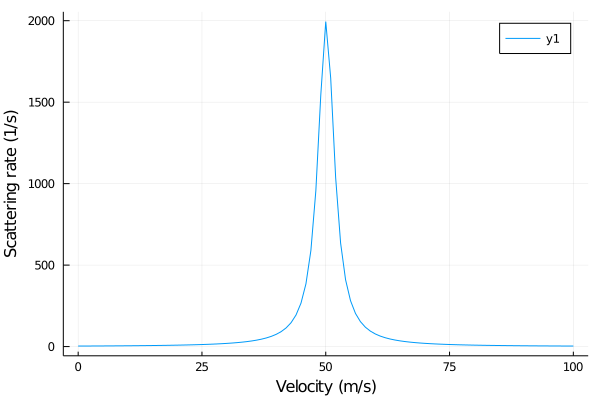

In [190]:
plot(vs,Rscatts0)
xlabel!("Velocity (m/s)")
ylabel!("Scattering rate (1/s)")

In [191]:
@inline function update(particles, p, s, dt)
    for i in 1:size(particles, 1)
        idx   = particles.idx[i]
        state = s.states[idx]
        
        r = particles.r[i]
        v = particles.v[i]
        
#         s.total_time[idx] += particles.dt[i]
        
        if ~p.noslow && p.addressed[state]
            dt′ = update_Rsc(r,v,p)
            state′ = sample(1:14,p.VBRs)
            particles.dt[i] = dt′
            particles.use_adaptive[i] = false
            v′ = velocity_vector(r, v, Δv, p)
            v′ += Δv .* random_unit3Dvector()
            s.photons[idx] += 1
            
            if state′ == 1 && update_N3(dt′,v′,p) #check if pumped into N=3
                state′ = 15
            end
        else
            if transverse_on(r[3]) && state == 15 #check if pumped back from N=3
                state′ = 1
            else
                state′ = state
            end
            v′ = v
            particles.use_adaptive[i] = true
        end
        s.states[idx] = state′
        s.vzs[idx] = v′[3]
        particles.v[i] = v′
        
        s.detectable[idx] |= is_detectable(r) #updating "or" operator (either s.detectable[idx] is true, or updates s.detectable[idx] to is_detectable(r))
    end
    return nothing
end

@inline function f(idx, r, v, p)
    
    return SVector(0., 0., 0.)
    
end

;

In [194]:
# Parameters required by beam propagation simulation
n = Int64(15e6)
save_every = 150
delete_every = 50
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(1e5)
alg = "rkf12"
use_adaptive = true
;

In [286]:
dt0 = 1e-5
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200 #mW
ζ = 0.15
δN3 = 2*pi*60*10^6
satN3 = 0.015
# satN3 = 1.

noslow = false
p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, δN3, satN3)
s = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)

  6.067183 seconds (15.00 M allocations: 5.839 GiB, 33.71% gc time)


In [233]:
dt0 = 1e-5
photons = zeros(Int64, n)
detectable = zeros(Bool, n)
states = ones(Int64, n)
vzs = zeros(Float64, n)
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200 #mW
ζ = 0.15
δN3 = 2*pi*80*10^6
satN3 = 0.001

noslow = true
p0 = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, δN3, satN3)
s0 = @params (vzs, photons, detectable, states)
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, dt_min, dt_max, abstol)

  3.491905 seconds (15.00 M allocations: 5.839 GiB, 36.15% gc time)


In [287]:
bright = [addressed[final_state] for final_state in s.states];

$\delta$ = 60 MHz

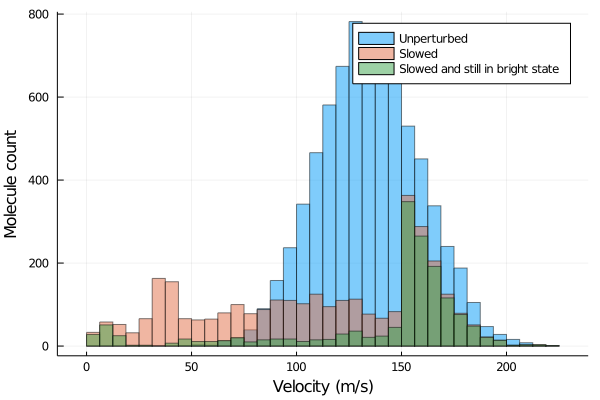

In [288]:
barhist(s0.vzs[s0.detectable], bins=0:25/4:225, alpha=0.5, label="Unperturbed")
barhist!(s.vzs[s.detectable], bins=0:25/4:225, alpha=0.5, label="Slowed")
barhist!(s.vzs[s.detectable .& bright], bins=0:25/4:225, alpha=0.5, label="Slowed and still in bright state")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [289]:
v_low_cut = 10
v_low = 0 .< s.vzs .< v_low_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected below ", v_low_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7575
Number detectable in slowed beam: 3269
Number detected (i.e. in bright states) in slowed beam: 1548
Number detected below 10 m/s in slowed beam: 58
Fraction of unperturbed below 10 m/s: 0.007656765676567656
Number slowed from 2e7 initial: 153135.31353135314


In [219]:
v_low_cut = 17.5
v_high_cut = 22.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7480
Number detectable in slowed beam: 2803
Number detected (i.e. in bright states) in slowed beam: 1407
Number detected between 17.5 and 22.5 m/s in slowed beam: 20
Fraction of unperturbed below 17.5 m/s: 0.00267379679144385
Number slowed from 2e7 initial: 53475.935828877


In [220]:
v_low_cut = 37.5
v_high_cut = 42.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7480
Number detectable in slowed beam: 2803
Number detected (i.e. in bright states) in slowed beam: 1407
Number detected between 37.5 and 42.5 m/s in slowed beam: 2
Fraction of unperturbed below 37.5 m/s: 0.00026737967914438503
Number slowed from 2e7 initial: 5347.593582887701


$\delta = 80$ MHz

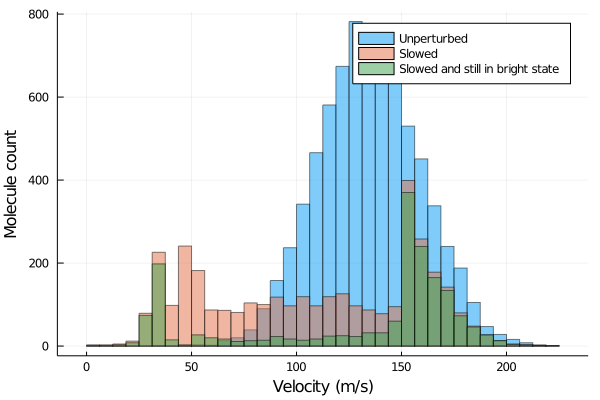

In [270]:
barhist(s0.vzs[s0.detectable], bins=0:25/4:225, alpha=0.5, label="Unperturbed")
barhist!(s.vzs[s.detectable], bins=0:25/4:225, alpha=0.5, label="Slowed")
barhist!(s.vzs[s.detectable .& bright], bins=0:25/4:225, alpha=0.5, label="Slowed and still in bright state")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [225]:
v_low_cut = 10
v_low = 0 .< s.vzs .< v_low_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected below ", v_low_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7451
Number detectable in slowed beam: 2773
Number detected (i.e. in bright states) in slowed beam: 1423
Number detected below 10 m/s in slowed beam: 17
Fraction of unperturbed below 10 m/s: 0.0022815729432290968
Number slowed from 2e7 initial: 45631.45886458194


In [219]:
v_low_cut = 17.5
v_high_cut = 22.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7480
Number detectable in slowed beam: 2803
Number detected (i.e. in bright states) in slowed beam: 1407
Number detected between 17.5 and 22.5 m/s in slowed beam: 20
Fraction of unperturbed below 17.5 m/s: 0.00267379679144385
Number slowed from 2e7 initial: 53475.935828877


In [220]:
v_low_cut = 37.5
v_high_cut = 42.5
v_low = v_low_cut .< s.vzs .< v_high_cut
println("Number detected in unperturbed beam: ", length(s0.vzs[s0.detectable]))
println("Number detectable in slowed beam: ", length(s.vzs[s.detectable]))
println("Number detected (i.e. in bright states) in slowed beam: ", length(s.vzs[s.detectable .& bright]))
println("Number detected between ", v_low_cut ," and ", v_high_cut, " m/s in slowed beam: ", length(s.vzs[s.detectable .& bright .& v_low]))
slow_frac = length(s.vzs[s.detectable .& bright .& v_low])/length(s0.vzs[s0.detectable])
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number slowed from 2e7 initial: ", slow_frac*2e7)

Number detected in unperturbed beam: 7480
Number detectable in slowed beam: 2803
Number detected (i.e. in bright states) in slowed beam: 1407
Number detected between 37.5 and 42.5 m/s in slowed beam: 2
Fraction of unperturbed below 37.5 m/s: 0.00026737967914438503
Number slowed from 2e7 initial: 5347.593582887701
